# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
fa.Banner().print_banner()

 
FISH processing repository by : 
Luis U. Aguilera, Joshua Cook, Tim Stasevich, and Brian Munsky. 
 ____________________________________________________________  
|                      ,#^^^^^^^%&&&                         | 
|  .&.                 &.           ,&&&___                  | 
|  &  &         ___&&&/                    (&&&&____         | 
|  &    &,____#&                   .       #.       %&**,    | 
|  /(                  &         ,%       &       %     ,&   | 
|    &          &.                       %.      %&%     &*  | 
|     &&         *         .%            &             &(    | 
|   &                &(           ,#     .%             ,.&  | 
|  &    _&&__#&.     &&           &.      ,&         ,%&     | 
|  &  (%        #&,___                      (-***%&%^        | 
|  & &                %&&&(,.      .*#&&&&&%.                | 
|                          &    ,%%%%                        | 
|___________________________/%%^_____________________________| 



----

# Parameters defined by the user 

----

### Paths to images

In [4]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')
# Path to images and masks
DUSP1 = True
if DUSP1 == True:
    data_folder_path =pathlib.Path('smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224')
    channels_with_nucleus = [2]                   # Channel to pass to python for nucleus segmentation
    channels_with_cytosol = [1]                    # Channel to pass to python for cytosol segmentation
    channels_with_FISH=[0]             # Channel to pass to python for spot detection
    path_to_masks_dir=pathlib.Path('smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224/masks_DUSP1_Dex_0min_20220224___nuc_100__cyto_200.zip')
    #path_to_masks_dir = None 

else:
    data_folder_path =pathlib.Path('smFISH_images/Eric_smFISH_images/20230511/GR_ICC_3hr_R1_1nM_0min_050823')
    channels_with_nucleus=[1]         # Channel to pass to python for nucleus segmentation
    channels_with_cytosol=None         # Channel to pass to python for cytosol segmentation
    channels_with_FISH=[0]             # Channel to pass to python for spot detection
    path_to_masks_dir=pathlib.Path('smFISH_images/Eric_smFISH_images/20230511/GR_ICC_3hr_R1_1nM_0min_050823/masks_GR_ICC_3hr_R1_1nM_0min_050823___nuc_100__cyto_200.zip')
    #path_to_masks_dir = None 

#data_folder_path =pathlib.Path('/home/luisub/Desktop/FISH_Processing/dataBases/test_2_colors')
#data_folder_path =pathlib.Path('/home/luisub/Desktop/FISH_Processing/dataBases/test_2_colors_GR_ICC_3hr_R1_10nM_40min_050823')
#data_folder_path = pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/20230311/A549_Dusp1_100nM_Dex_0min_031123') #Sawyer cells A459

#path_to_masks_dir = None 

In [5]:
# Cellpose models

nuclei_model_path = None #'/home/luisub/Desktop/FISH_Processing/cell_segmentation/temp_models/nuclei_gapdh/nuclei_gapdh'
cyto_model_path =  None #'/home/luisub/Desktop/FISH_Processing/cell_segmentation/temp_models/cyto_gapdh/cyto_gapdh'

### Parameters for segmentation and spot detection

In [6]:
diameter_nucleus=100                         # Approximate nucleus size in pixels
diameter_cytosol=200                         # Approximate cytosol size in pixels

psf_z=350                                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=160                                   # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers

voxel_size_z=500                             # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=160                            # Microscope conversion px to nanometers in the xy axis.

#channels_with_FISH=[0]                       # Channel to pass to python for spot detection
optimization_segmentation_method= 'default' #'default'  #'default'  #'default' #'default'   # optimization_segmentation_method = 'default', 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , None
save_all_images=0                             # To save all images for all the z-slices
save_filtered_images = True                 # To save filtered images.
number_of_images_to_process = 2 #None           # Use an integer to process a subset of images. None is used to indicate that all images need to be processed.
minimum_spots_cluster = 4                    # Minimal value used to define a cluster.
threshold_for_spot_detection=None #400#None            # To select an specific threshold for spot detection. The default is None, and use automated threshold detection.
show_plots=1                                 # Flag to show plots
send_data_to_NAS=0                           # If data sent back to NAS use 1
download_data_from_NAS=1                     # If data downloaded from NAS use 1
remove_z_slices_borders=0                    # Use this flag to remove 2 z-slices from the top and bottom of the stack. This is needed to remove z-slices that are out of focus.
save_pdf_report=0
display_spots_on_multiple_z_planes=0
remove_out_of_focus_images = True,
sharpness_threshold =1.10


In [7]:
#channels_with_nucleus = [2]                   # Channel to pass to python for nucleus segmentation
#channels_with_cytosol = [1]                    # Channel to pass to python for cytosol segmentation

## Downloading data from NAS

In [8]:
%%capture
# Download data from NAS
convert_to_standard_format = False
if convert_to_standard_format == False:
    local_data_dir, masks_dir, _, _, _,list_images = fa.Utilities().read_images_from_folder( path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
    number_color_channels = list_images[0].shape[-1]
else:
    ####################################################################
    #### Parameters to reformat images from the terminator scope ####
    number_color_channels = 0                    # Only use if it is needed to convert to standard format
    number_of_fov = 0                            # Only use if it is needed to convert to standard format     
    ####################################################################
    local_data_dir, masks_dir, _, _, list_images= fa.Utilities().convert_to_standard_format(data_folder_path=data_folder_path, 
                                                                                path_to_config_file=path_to_config_file, 
                                                                                download_data_from_NAS = download_data_from_NAS,
                                                                                number_color_channels=number_color_channels)

In [9]:
# print('image shape:',list_images[0].shape )
# num_z = list_images[0].shape[0]
# selected_color_channel = 0
# _, axes = plt.subplots(nrows = 1, ncols = num_z, figsize = (30, 5))
# for i in range (num_z):
#     simulated_image_removed_extreme_values = fa.RemoveExtrema(list_images[0][i,:,:,selected_color_channel],min_percentile=0, max_percentile=99.9).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
#     axes[i].imshow( simulated_image_removed_extreme_values ) #list_images[0][i,:,:,selected_color_channel])
#     axes[i].grid(False); axes[i].set_xticks([]); axes[i].set_yticks([])
    
# 0= spots
# 1= GAPDH
# 2 = DAPI


In [10]:
# print('image shape:',list_images[0].shape )
# num_z = 3 #list_images[0].shape[0]
# start_z=10
# selected_color_channel = 0
# _, axes = plt.subplots(nrows = 1, ncols = num_z, figsize = (30, 15))
# for i in range (0,num_z):
#     simulated_image_removed_extreme_values = fa.RemoveExtrema(list_images[0][i+num_z+start_z,:,:,selected_color_channel],min_percentile=0, max_percentile=99.5).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
#     axes[i].imshow( simulated_image_removed_extreme_values ) #list_images[0][i,:,:,selected_color_channel])
#     axes[i].grid(False); axes[i].set_xticks([]); axes[i].set_yticks([])

## Running the pipeline

----


 Output folder name :  DUSP1_Dex_0min_20220224___nuc_100__cyto_200__psfz_350__psfyx_160__ts_None

 ###################### 
        IMAGE : 0
 ###################### 
    Image Name :   ROI001_XY1645813308_Z00_T0_merged.tif


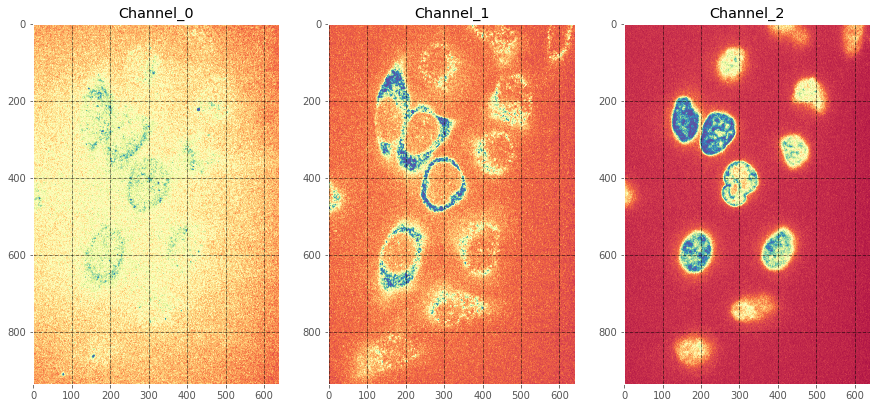

    Original Image Shape :                    [27, 936, 640, 3]
    Image sharpness metric :                  1.216


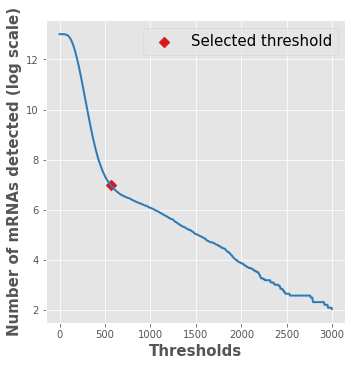

Z-Slice:  13


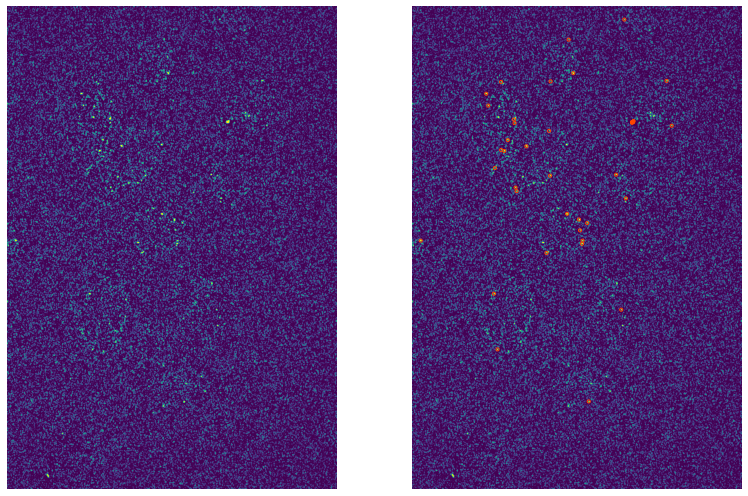

    Intensity threshold for spot detection :  [563.0]
    Average detected spots per cell :         [95]
    Maximum detected spots per cell :         [177]


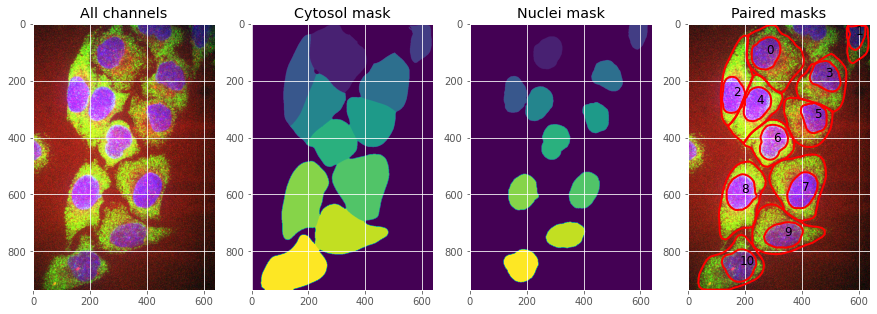


 ###################### 
        IMAGE : 1
 ###################### 
    Image Name :   ROI002_XY1645813309_Z00_T0_merged.tif


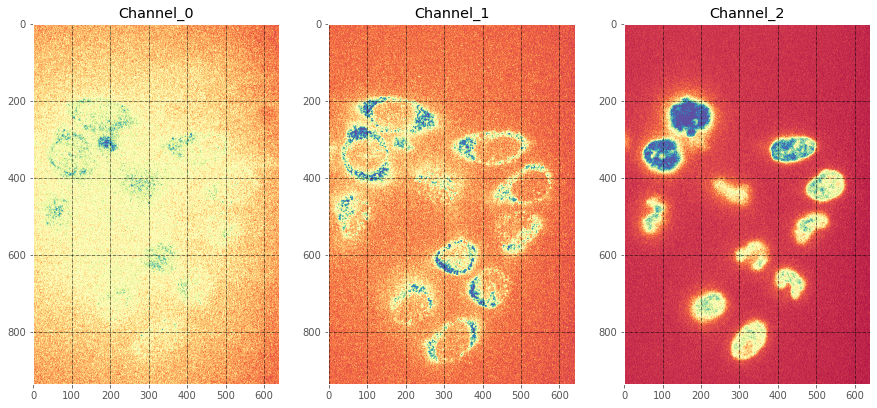

    Original Image Shape :                    [27, 936, 640, 3]
    Image sharpness metric :                  1.214


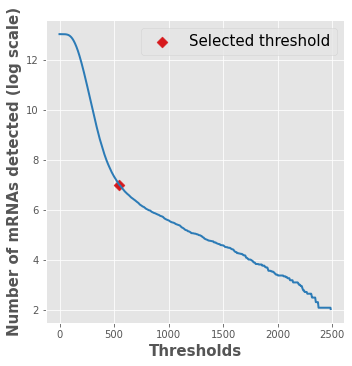

Z-Slice:  13


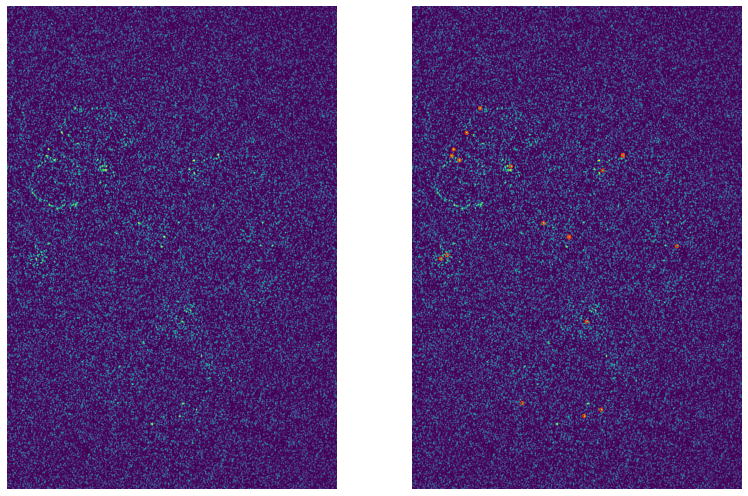

    Intensity threshold for spot detection :  [547.0]
    Average detected spots per cell :         [96]
    Maximum detected spots per cell :         [228]


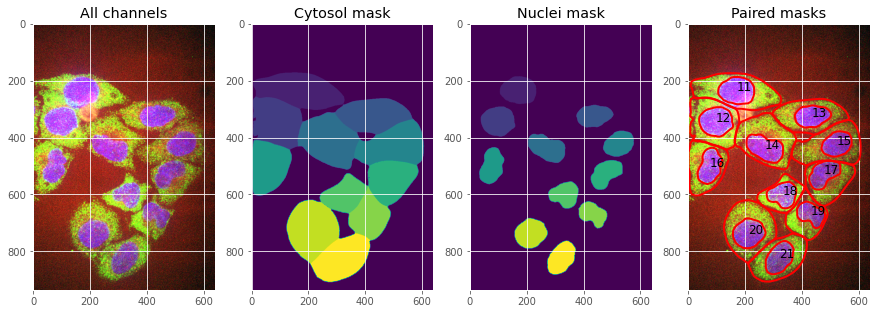

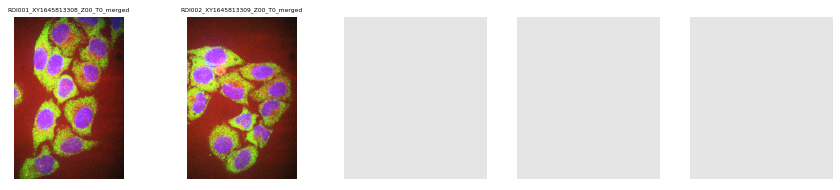

In [11]:
dataframe_FISH,_,_,_,output_identification_string = fa.PipelineFISH(local_data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, 
                                       diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  voxel_size_z=voxel_size_z,
                                       voxel_size_yx=voxel_size_yx ,psf_z=psf_z,psf_yx=psf_yx, show_plots=show_plots,  
                                       file_name_str=data_folder_path.name, 
                                       optimization_segmentation_method=optimization_segmentation_method,
                                       save_all_images=save_all_images,
                                       threshold_for_spot_detection=threshold_for_spot_detection,
                                       save_filtered_images=save_filtered_images,
                                       number_of_images_to_process=number_of_images_to_process,
                                       remove_z_slices_borders=remove_z_slices_borders,
                                       save_pdf_report=save_pdf_report,
                                       display_spots_on_multiple_z_planes=display_spots_on_multiple_z_planes,
                                       model_nuc_segmentation='nuclei', # ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4']
                                       model_cyto_segmentation='cyto', # ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4']
                                       pretrained_model_nuc_segmentation=None, #nuclei_model_path,
                                       remove_out_of_focus_images=remove_out_of_focus_images,
                                       pretrained_model_cyto_segmentation=cyto_model_path ).run()

## Extracting data from the dataframe

----

In [12]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.head()


image_id  cell_id  spot_id  nuc_loc_y  nuc_loc_x  cyto_loc_y  cyto_loc_x  \
0         0        0        0        103        273         116         302   
1         0        0        1        103        273         116         302   
2         0        0        2        103        273         116         302   
3         0        0        3        103        273         116         302   
4         0        0        4        103        273         116         302   

   nuc_area_px  cyto_area_px  cell_area_px  ...  pseudo_cyto_int_ch_2  \
0         9037         22930         31967  ...             728.55886   
1         9037         22930         31967  ...             728.55886   
2         9037         22930         31967  ...             728.55886   
3         9037         22930         31967  ...             728.55886   
4         9037         22930         31967  ...             728.55886   

   nuc_cyto_int_ratio_ch_0  nuc_cyto_int_ratio_ch_1  nuc_cyto_int_ratio_ch_2  \
0                 0.993873                 0.788197                 1.909602   
1                 0.993873                 0.788197                 1.909602   
2                 0.993873                 0.788197                 1.909602   
3                 0.993873                 0.788197                 1.909602   
4                 0.993873                 0.788197                 1.909602   

   nuc_pseudo_cyto_int_ratio_ch_0  nuc_pseudo_cyto_int_ratio_ch_1  \
0                        0.989246                        0.769045   
1                        0.989246                        0.769045   
2                        0.989246                        0.769045   
3                        0.989246                        0.769045   
4                        0.989246                        0.769045   

   nuc_pseudo_cyto_int_ratio_ch_2  spot_int_ch_0 spot_int_ch_1 spot_int_ch_2  
0                        1.839952       769.7333         -39.6      688.0667  
1                        1.839952         1182.2      -28.4667      220.4667  
2                        1.839952       699.2667     -209.7333      243.2667  
3                        1.839952       447.4667       74.8667      218.2667  
4                        1.839952       730.2667          83.4      344.0667  

[5 rows x 39 columns]

In [13]:
print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_int_ch_0','pseudo_cyto_int_ch_0','complete_cell_int_ch_0' ,'cyto_int_ch_0']]  )

     nuc_int_ch_0 pseudo_cyto_int_ch_0 complete_cell_int_ch_0 cyto_int_ch_0
0        1274.785           1288.64371              1280.4225    1282.64431
83     1007.49801           1028.07737             1032.69521    1081.17127
100    1480.39216           1448.72356             1421.23441    1388.03469
277    1251.72477           1281.78839             1278.25492     1292.6585
319    1447.23687           1495.72641             1463.55658    1472.12773
451    1368.53075           1389.79567               1395.241      1408.795
581    1516.13569           1454.51507              1490.4108    1466.77349
685     1367.7096           1378.26658             1370.52626     1371.7317
814    1474.01881           1453.37679             1440.79271    1424.44842
955    1308.48853           1300.11895             1310.19603    1311.05902
1008   1255.16166           1200.70367              1219.2071    1199.37854
1045   1503.12008             1512.751              1449.3395    1422.14722
1273   1469.

In [14]:
print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_int_ch_1','pseudo_cyto_int_ch_1' ,'complete_cell_int_ch_1','cyto_int_ch_1']]  )

     nuc_int_ch_1 pseudo_cyto_int_ch_1 complete_cell_int_ch_1 cyto_int_ch_1
0       989.93648           1287.22892              1180.7494    1255.95116
83      854.23983             940.7592              954.08033    1089.50649
100    1219.21313           1512.43536             1563.53501    1777.20753
277     991.23454           1199.80753              1180.7935    1283.70877
319    1231.07768           1816.39675             1661.25181    1938.34076
451    1033.30647           1289.66337             1207.61441    1296.37262
581    1416.71372           1666.66477             1633.26848    1832.24975
685       1009.57           1394.67059             1332.90918    1471.28887
814     1228.0897           1669.79327             1566.09395    1732.36206
955    1068.15176           1309.55838             1247.56334    1338.23942
1008   1031.40999           1180.89458             1188.63066    1275.33621
1045    1184.6283           1663.94437              1501.0172    1660.98821
1273    1256

In [15]:
#print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_int_ch_2','pseudo_cyto_int_ch_2' ,'complete_cell_int_ch_2','cyto_int_ch_2']]  )

In [16]:
#print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_cyto_int_ratio_ch_0','nuc_cyto_int_ratio_ch_1' ,'nuc_cyto_int_ratio_ch_2']]  )

In [17]:
#print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_pseudo_cyto_int_ratio_ch_0','nuc_pseudo_cyto_int_ratio_ch_1' ,'nuc_pseudo_cyto_int_ratio_ch_2']]  )

## Plots

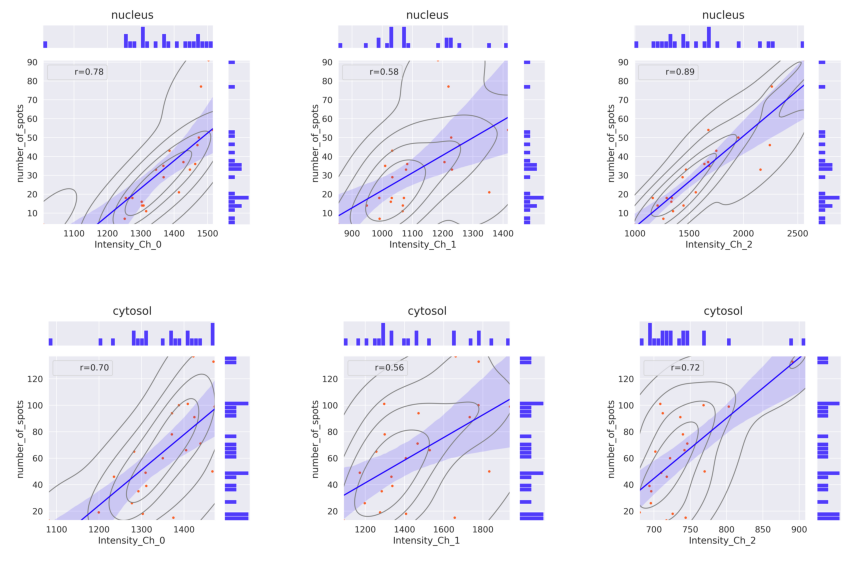

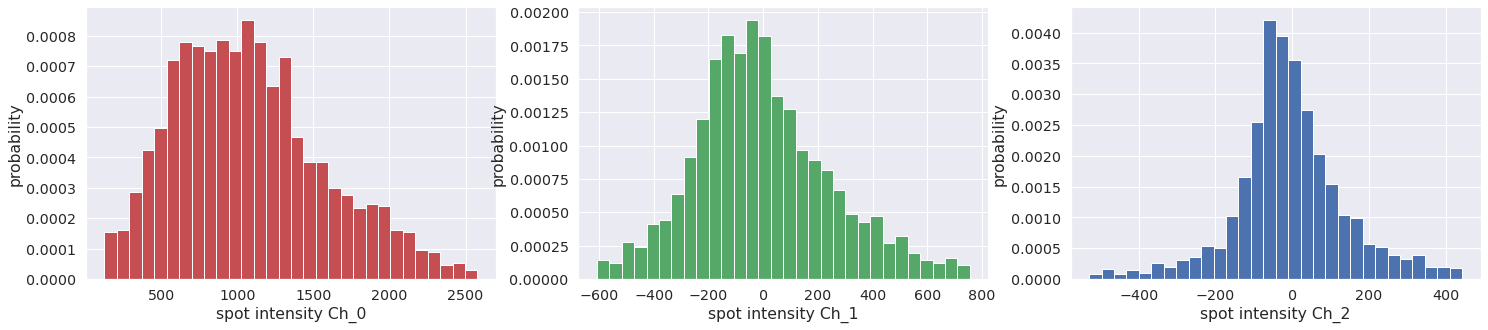

<Figure size 432x288 with 0 Axes>

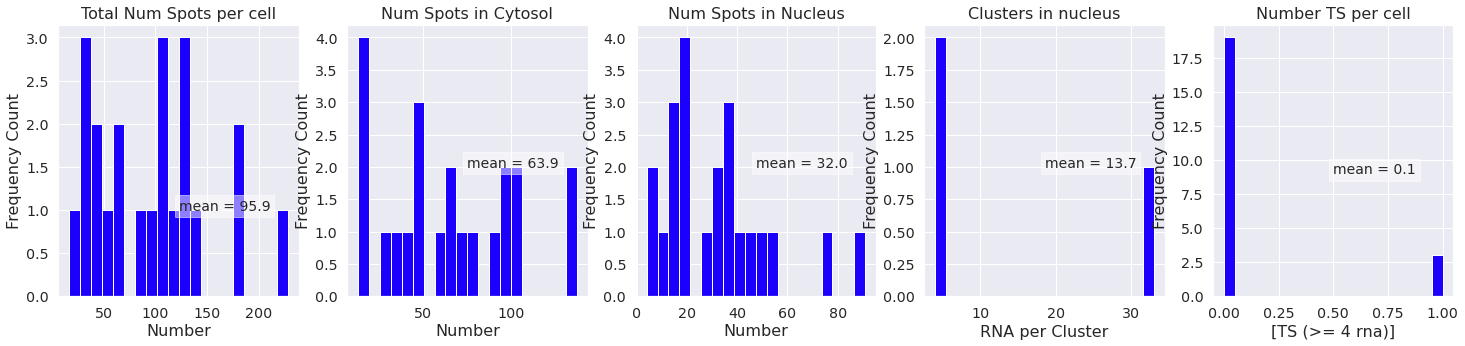

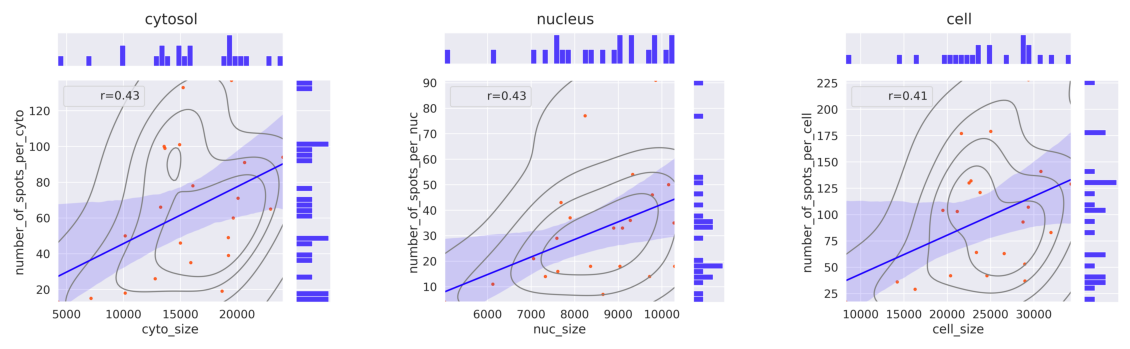

In [18]:
list_files_distributions = fa.Plots().plot_all_distributions(dataframe_FISH,channels_with_cytosol, channels_with_nucleus,channels_with_FISH,minimum_spots_cluster,output_identification_string )

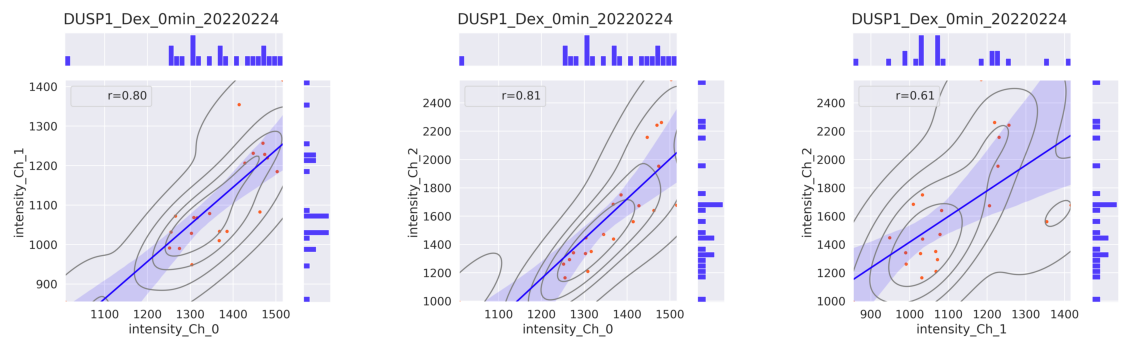

In [19]:
file_plots_bleed_thru = fa.Plots().plot_scatter_bleed_thru(dataframe_FISH, channels_with_cytosol, channels_with_nucleus,output_identification_string)

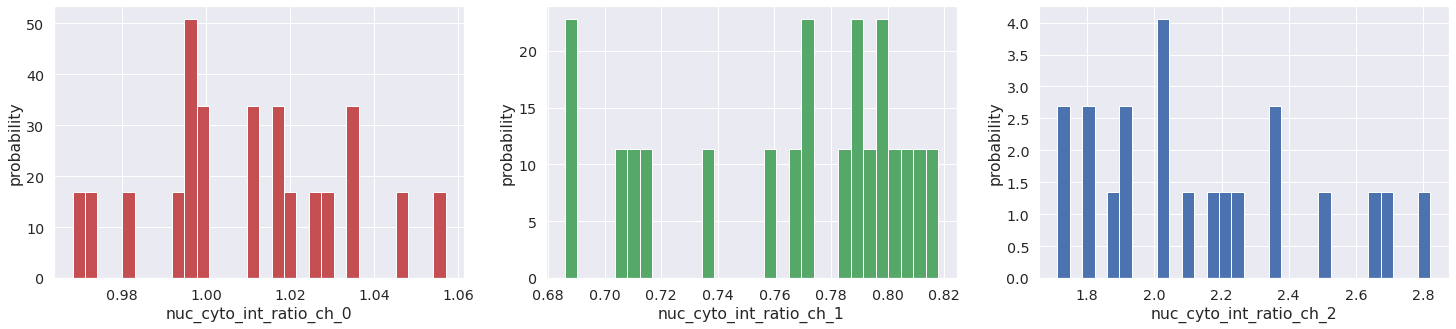

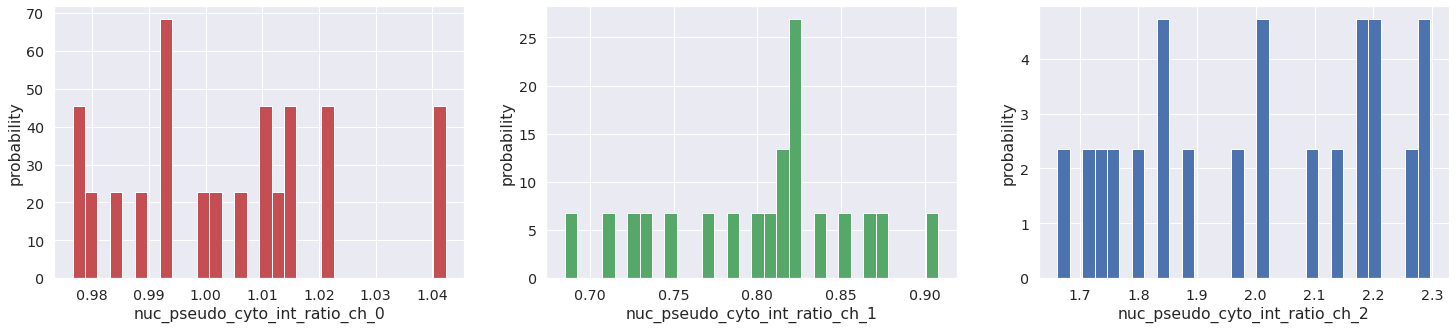

In [20]:
# plots for cytosol nucleus intensity ratios
if not fa.Utilities().is_None(channels_with_cytosol):
    file_plots_int_ratio = fa.Plots().plot_nuc_cyto_int_ratio_distributions(dataframe_FISH,output_identification_string=None,plot_for_pseudo_cytosol=False)
else:
    file_plots_int_ratio = None
file_plots_int_pseudo_ratio = fa.Plots().plot_nuc_cyto_int_ratio_distributions(dataframe_FISH,output_identification_string=None,plot_for_pseudo_cytosol=True)


## Saving data

In [21]:
# Saving data and plots, and sending data to NAS
fa.Utilities().save_output_to_folder(output_identification_string, data_folder_path, 
                                   list_files_distributions=list_files_distributions,
                                   file_plots_bleed_thru=file_plots_bleed_thru,
                                   file_plots_int_ratio=file_plots_int_ratio,
                                   file_plots_int_pseudo_ratio=file_plots_int_pseudo_ratio,
                                   channels_with_FISH=channels_with_FISH,save_pdf_report=save_pdf_report)

# sending data to NAS
analysis_folder_name, mask_dir_complete_name = fa.Utilities().sending_data_to_NAS(output_identification_string, data_folder_path, path_to_config_file, path_to_masks_dir, diameter_nucleus, diameter_cytosol, send_data_to_NAS, masks_dir)

# Moving the complete analysis folder to final analyses folder 
fa.Utilities().move_results_to_analyses_folder( output_identification_string, data_folder_path, mask_dir_complete_name, path_to_masks_dir, save_filtered_images, download_data_from_NAS )

In [22]:
# Extracting TS intensity. for all cells

number_cells = dataframe_FISH['cell_id'].nunique()
minimum_spots_cluster = 2
ts_size =  dataframe_FISH.loc[ (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) &  (dataframe_FISH['cluster_size']>=minimum_spots_cluster)  & (dataframe_FISH['is_cell_fragmented']!=-1)   ].cluster_size.values

ts_size

array([ 4,  4, 33])

In [23]:
#list_ts = sorted(dataframe.loc[ (dataframe['cell_id']==df_index) & (dataframe['is_cluster']==True) &   (dataframe['cluster_size']>=minimum_spots_cluster)  ].cluster_size.values, reverse=True)
#min_length = min(len(ts_array), len(list_ts))
#ts_array[:min_length] = list_ts[:min_length]
# Size of the nucleus of each cell
#nuc_area = dataframe.loc[   (dataframe['cell_id']==df_index) ].nuc_area_px.values[0]   